In [55]:
import os

import tensorflow as tf
from tensorflow import keras

## Load model

In [56]:
close_model= tf.keras.models.load_model('saved_models/close_model.keras')
open_model = tf.keras.models.load_model('saved_models/open_model.keras')

In [57]:
import yfinance as yf
def download_stock(stock, start_date, end_date):
    df = yf.download(stock, start= start_date, end= end_date)
    df['Prev_Close'] = df['Close'].shift(1)
    return df

# for symbol in ['MSFT', 'IWO', 'VFINX', 'BTC-USD']
apple_stock_df = download_stock(stock = 'AAPL', start_date='2015-7-14', end_date='2023-7-14')
    

[*********************100%%**********************]  1 of 1 completed


In [58]:
import numpy as np
import pandas as pd
data_close = apple_stock_df.filter(['Close'])
data_open = apple_stock_df.filter(['Open'])

close_np_data = data_close.values
open_np_data = data_open.values

split_percent = 0.2
split_position = int(len(apple_stock_df) * (1 - split_percent))

In [59]:
from sklearn.preprocessing import MinMaxScaler
close_scaler = MinMaxScaler(feature_range=(0,1))
close_scaled_data = close_scaler.fit_transform(open_np_data)
open_scalar = MinMaxScaler(feature_range=(0,1))
open_scaled_data = open_scalar.fit_transform(open_np_data)

In [60]:
close_test_data= close_scaled_data[split_position-60: , : ]
open_test_data = open_scaled_data[split_position-60: , : ]

close_x_test=[]
open_x_test = []

close_y_test= close_np_data[split_position:,:]
open_y_test = open_np_data[split_position:,:]

for i in range(60, len(close_test_data)):
    close_x_test.append(close_test_data[i-60:i,0])
    open_x_test.append(open_test_data[i-60:i,0])
    
close_x_test=np.array(close_x_test)
open_x_test = np.array(open_test_data)

close_x_test=np.reshape(close_x_test,(close_x_test.shape[0], close_x_test.shape[1], 1))
open_x_test=np.reshape(open_test_data,(open_test_data.shape[0], open_test_data.shape[1], 1))


In [61]:
close_predictions = close_model.predict(close_x_test)
close_predictions = close_scaler.inverse_transform(close_predictions)

open_predictions = close_model.predict(open_x_test)
open_predictions = open_scalar.inverse_transform(open_predictions)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [62]:
day_by_day_close = data_close[split_position:]

In [63]:
day_by_day_close

,Close
Date,
2021-12-03,161.839996
2021-12-06,165.320007
2021-12-07,171.179993
2021-12-08,175.080002
2021-12-09,174.559998
...,...
2023-07-07,190.679993
2023-07-10,188.610001
2023-07-11,188.080002


In [64]:
day_by_day_open = data_open[split_position:]

In [65]:
day_by_day_open

,Open
Date,
2021-12-03,164.020004
2021-12-06,164.289993
2021-12-07,169.080002
2021-12-08,172.130005
2021-12-09,174.910004
...,...
2023-07-07,191.410004
2023-07-10,189.259995
2023-07-11,189.160004


Final Portfolio Value: $12328.62


Profit: $2328.62


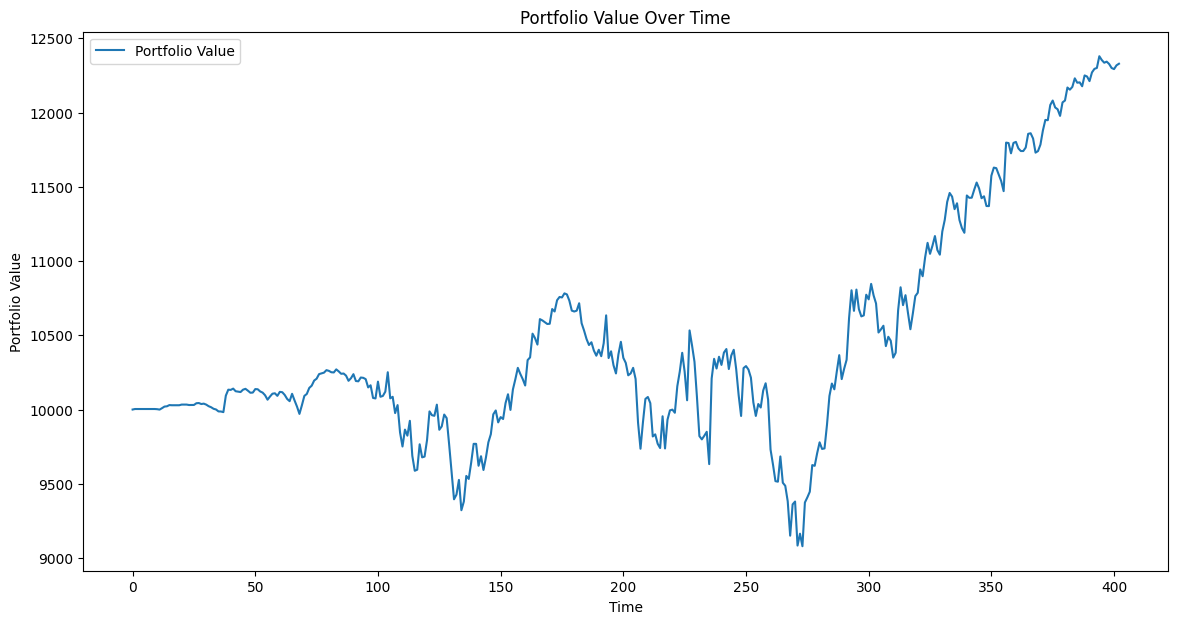

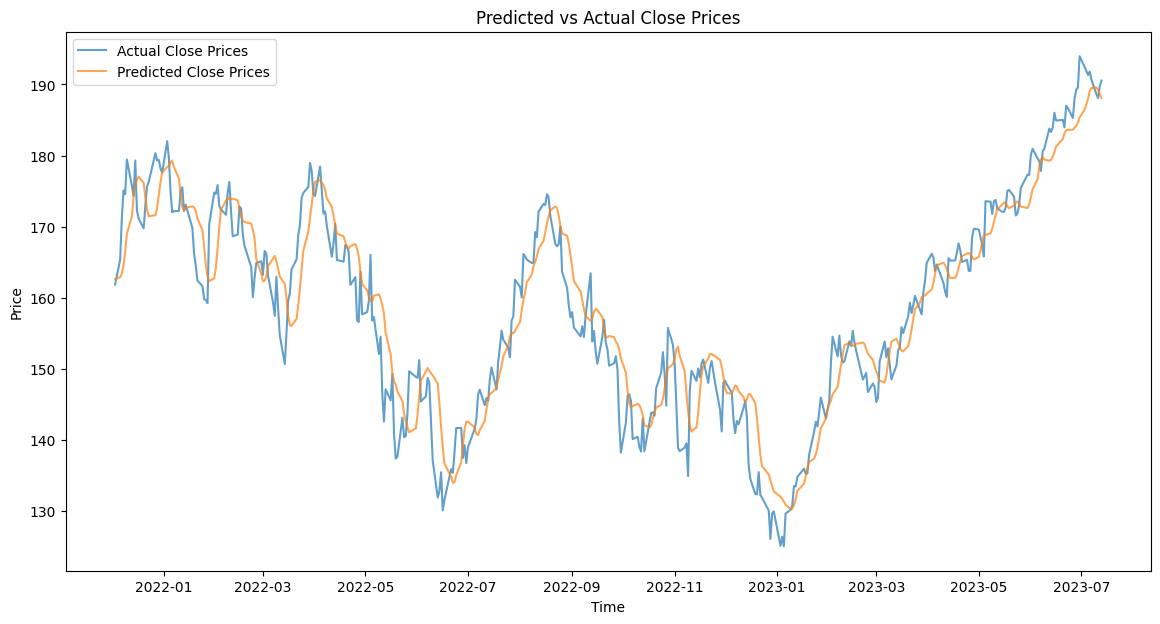

In [66]:
import matplotlib.pyplot as plt

initial_balance = 10000  # Starting with $10,000
balance = initial_balance
positions = 0  # Number of stocks currently held
portfolio_values = []  # To store the portfolio value over time

for i in range(len(close_predictions)):
    # Buy condition
    if close_predictions[i] > day_by_day_close.iloc[i]['Close']:
        positions += 1
        balance -= day_by_day_close.iloc[i]['Close']
    # Sell condition
    elif close_predictions[i] < day_by_day_close.iloc[i]['Close'] and positions > 0:
        positions -= 1
        balance += day_by_day_close.iloc[i]['Close']

    current_value = balance + positions * day_by_day_close.iloc[i]['Close']
    portfolio_values.append(current_value)
# Calculate final portfolio value
final_balance = balance + positions * day_by_day_close.iloc[-1]['Close']
profit = final_balance - initial_balance

print(f"Final Portfolio Value: ${final_balance:.2f}")
print(f"Profit: ${profit:.2f}")

# Plot the portfolio value over time
plt.figure(figsize=(14, 7))
plt.plot(portfolio_values, label='Portfolio Value')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()

# Plot the predicted vs actual closing prices
plt.figure(figsize=(14, 7))
plt.plot(day_by_day_close.index, day_by_day_close, label='Actual Close Prices', alpha=0.7)
plt.plot(day_by_day_close.index, close_predictions, label='Predicted Close Prices', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Predicted vs Actual Close Prices')
plt.legend()
plt.show()

In [67]:
import matplotlib.pyplot as plt

initial_balance = 10000  # Starting with $10,000
balance = initial_balance
positions = 0  # Number of stocks currently held
portfolio_values = []  # To store the portfolio value over time

for i in range(len(open_predictions)):
    # Buy condition
    if close_predictions[i] > day_by_day_close.iloc[i]['Close']:
        positions += 1
        balance -= day_by_day_close.iloc[i]['Close']
    # Sell condition
    elif close_predictions[i] < day_by_day_close.iloc[i]['Close'] and positions > 0:
        positions -= 1
        balance += day_by_day_close.iloc[i]['Close']

    current_value = balance + positions * day_by_day_close.iloc[i]['Close']
    portfolio_values.append(current_value)
# Calculate final portfolio value
final_balance = balance + positions * day_by_day_close.iloc[-1]['Close']
profit = final_balance - initial_balance

print(f"Final Portfolio Value: ${final_balance:.2f}")
print(f"Profit: ${profit:.2f}")

# Plot the portfolio value over time
plt.figure(figsize=(14, 7))
plt.plot(portfolio_values, label='Portfolio Value')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()

# Plot the predicted vs actual closing prices
plt.figure(figsize=(14, 7))
plt.plot(day_by_day_close.index, day_by_day_close, label='Actual Close Prices', alpha=0.7)
plt.plot(day_by_day_close.index, close_predictions, label='Predicted Close Prices', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Predicted vs Actual Close Prices')
plt.legend()
plt.show()

IndexError: index 403 is out of bounds for axis 0 with size 403